# LIBS

In [27]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import csv
import matplotlib.pyplot as plt

# Data

Parameters

In [28]:
DATA_PATH = os.path.join('model/data')
SEQUENCE_LENGTH = 25 # 25 frames per sequence    

Load Data

In [55]:
with open("model/custom_model_label.csv", encoding='utf-8-sig') as f:
            label_map = csv.reader(f)
            label_map = {
                row[0]: index for index, row in enumerate(label_map)
            }
            actions = list(label_map.keys())

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(SEQUENCE_LENGTH):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
print(X[1].shape)  # ti stampa la shape del primo esempio (dovrebbe essere (25, 126))


[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]
 [0 0 1]]
X_train: (28, 25, 258), y_train: (28, 3)
X_test: (2, 25, 258), y_test: (2, 3)
(25, 258)


Logs

In [44]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# MODEL

Def Model

In [45]:
model = Sequential()
model.add(Input(shape=(X.shape[1:])))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(actions), activation='softmax'))

Compile Model

In [46]:
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

Fit Model (Only When Re-Run the Model)

In [47]:
history = model.fit(X_train, y_train, epochs=500,validation_split=0.2, callbacks=[tb_callback])

Epoch 1/500
1/1 [==============================] - 5s 5s/step - loss: 1.1126 - categorical_accuracy: 0.2727 - val_loss: 1.0963 - val_categorical_accuracy: 0.1667
Epoch 2/500
1/1 [==============================] - 0s 133ms/step - loss: 1.0370 - categorical_accuracy: 0.3636 - val_loss: 1.0407 - val_categorical_accuracy: 0.5000
Epoch 3/500
1/1 [==============================] - 0s 102ms/step - loss: 0.9836 - categorical_accuracy: 0.6818 - val_loss: 0.9948 - val_categorical_accuracy: 0.5000
Epoch 4/500
1/1 [==============================] - 0s 51ms/step - loss: 0.8903 - categorical_accuracy: 0.7273 - val_loss: 0.9758 - val_categorical_accuracy: 0.5000
Epoch 5/500
1/1 [==============================] - 0s 55ms/step - loss: 0.8282 - categorical_accuracy: 0.6818 - val_loss: 0.9064 - val_categorical_accuracy: 0.5000
Epoch 6/500
1/1 [==============================] - 0s 67ms/step - loss: 0.7482 - categorical_accuracy: 0.8182 - val_loss: 0.8623 - val_categorical_accuracy: 0.5000
Epoch 7/500
1/1 

Trainig graph

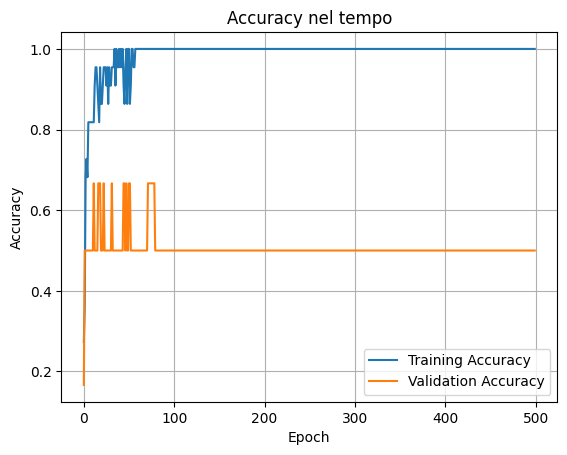

In [48]:
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy nel tempo')
plt.legend()
plt.grid(True)
plt.show()

Load Model

In [ ]:
# model = load_model('model/save_model.keras')

Save Model

In [49]:
model.save('model/save_model.keras')

Sumary Model

In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 25, 64)            82688     
                                                                 
 lstm_10 (LSTM)              (None, 25, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 3)                 99        
                                                                 
Total params: 237,251
Trainable params: 237,251
Non-tr

# Evaluation

In [51]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

Test data

In [52]:
yhat = model.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

1/1 [==============================] - 1s 804ms/step


Confusion Matrix

In [53]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[1, 0],
        [0, 1]],

       [[1, 0],
        [0, 1]]], dtype=int64)

Accuracyt Score (1 is good, 0 bad)

In [54]:
accuracy_score(ytrue, yhat)

1.0